In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clean-ktvcsc/out.csv


In [56]:
df = pd.read_csv('/kaggle/input/clean-ktvcsc/out.csv', index_col=0, low_memory=False)
df.head()

,StoreCode,BillCode,BoxSpending,CustomerNumber,Age,Membership,UniqueID
0,107,1602010011,2857,6,30~39,0,1602010011107
10,107,1602010028,2080,4,20~29,0,1602010028107
30,107,1602010034,1300,2,30~39,0,1602010034107
39,107,1602010037,2133,5,20~29,0,1602010037107
46,107,1602010040,1161,7,20~29,0,1602010040107


In [57]:
df['Age'].unique()

array(['30~39', '20~29', '19 Below', '40~49', '50 Above'], dtype=object)

In [58]:
# 先Label encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['Age'] = labelencoder.fit_transform(df['Age'])
df.head()

,StoreCode,BillCode,BoxSpending,CustomerNumber,Age,Membership,UniqueID
0,107,1602010011,2857,6,2,0,1602010011107
10,107,1602010028,2080,4,1,0,1602010028107
30,107,1602010034,1300,2,2,0,1602010034107
39,107,1602010037,2133,5,1,0,1602010037107
46,107,1602010040,1161,7,1,0,1602010040107


In [59]:
# 再one-hot-encode
df = pd.get_dummies(data=df, columns=['Age'])
df.head()

,StoreCode,BillCode,BoxSpending,CustomerNumber,Membership,UniqueID,Age_0,Age_1,Age_2,Age_3,Age_4
0,107,1602010011,2857,6,0,1602010011107,0,0,1,0,0
10,107,1602010028,2080,4,0,1602010028107,0,1,0,0,0
30,107,1602010034,1300,2,0,1602010034107,0,0,1,0,0
39,107,1602010037,2133,5,0,1602010037107,0,1,0,0,0
46,107,1602010040,1161,7,0,1602010040107,0,1,0,0,0


# X -> CusomerNumber,Age,Membership ,y -> BoxSpending

## 使用LinearRegression

In [60]:
# 建置特徵集
X = df[['CustomerNumber','Age_0','Age_1','Age_2','Age_3','Age_4','Membership']]

# 建置標籤集
y = df['BoxSpending'] 

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import cross_val_score,KFold

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)
model = LinearRegression().fit(X_train,y_train)
print("Linear model intercept: {}".format(model.intercept_))
print("Linear model coeff (w): {}".format(model.coef_))

Linear model intercept: 238.00303166609342
Linear model coeff (w): [ 277.4505283  -611.88366726 -140.87337024  190.36747388  278.3351031
  284.05446053 -499.89090154]


## When score is called on regressors, the coefficient of determination - R2 is calculated by default R2==1 is the best

In [62]:
print("R2 score on (training): {}".format(model.score(X_train,y_train)))
print("R2 score on (testing): {}".format(model.score(X_test,y_test)))

R2 score on (training): 0.41617481342538976
R2 score on (testing): 0.41712677324218317


In [63]:
y_pred = model.predict(X_test)

## 畫圖比較結果

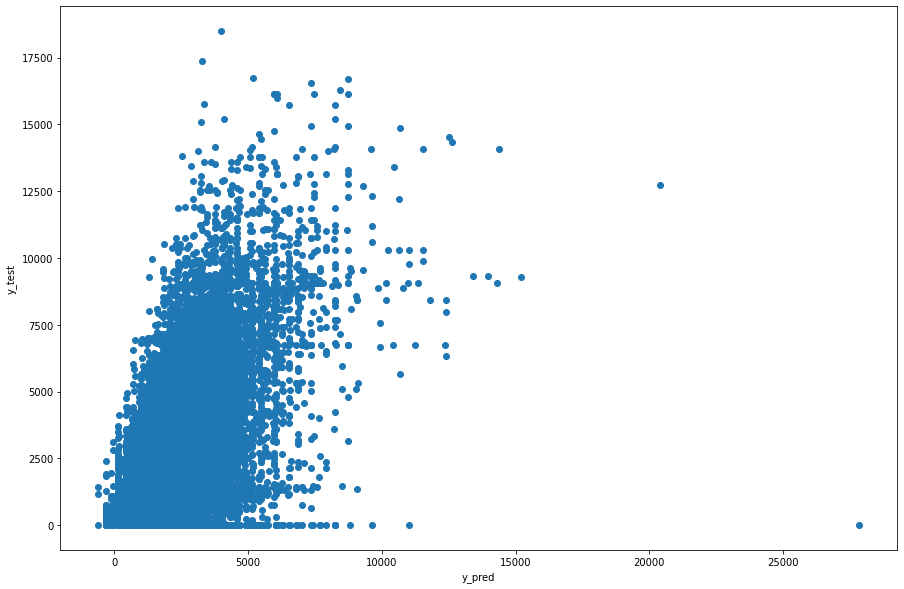

In [64]:
# plotting the y_test vs y_pred
plt.figure(figsize=(15,10))
plt.scatter(y_pred, y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

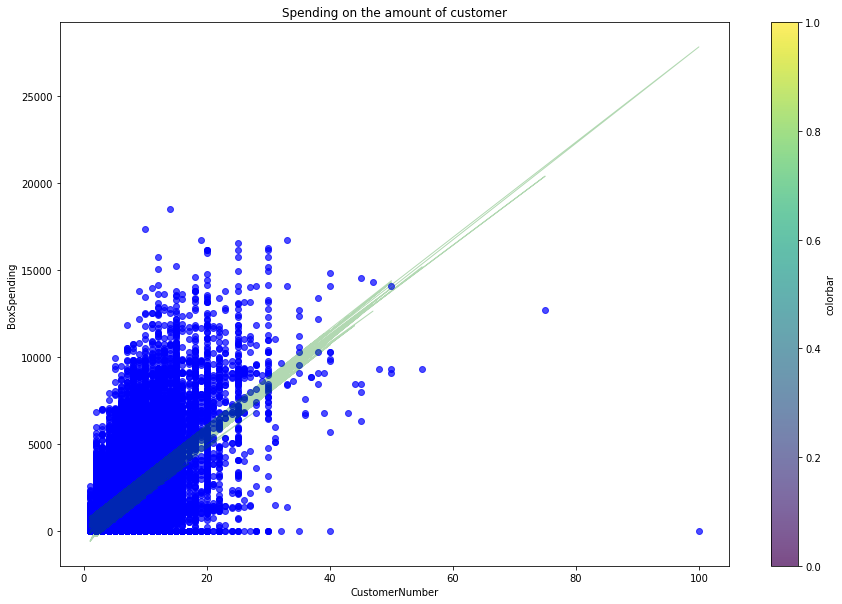

In [65]:
plt.figure(figsize=(15,10))
plt.scatter(X_test.CustomerNumber,y_test,color='blue',alpha=0.7)
plt.plot(X_test.CustomerNumber,y_pred,color='green',linewidth=1,alpha=0.3)
plt.colorbar(label='colorbar')
plt.xlabel('CustomerNumber')
plt.ylabel('BoxSpending')
plt.title("Spending on the amount of customer")
plt.show()

## 

## 利用訓練好的model做預測

In [72]:
# if i have a row of transaction
X_row_data = np.array([8,0,0,1,0,0,0]).reshape(1,-1)  # CustomerNumber:8,age 30~39 -> 00100 ,membership:0
how_much_they_spend = model.predict(X_row_data)
print(f'They will spend around{how_much_they_spend} NTD dollars')

They will spend around[2647.97473196] NTD dollars


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


## 使用KNN Regressor

## 根均方誤差 的值越低，表示預測模型越精準。完美預測模型 (能始終預測到實際預期值的假設性預測模型) 的 根均方誤差 值將會是 0。

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import mean_squared_error # 實際值跟預測值的差平方和
from math import sqrt
#KVals=range(1,20,1) # 先以odd number try 看看
#error_list=[]
#for k in KVals:
#    clf = neighbors.KNeighborsRegressor(n_neighbors=k) # 這邊要用回歸,要的是一個scalar,而不是分類
#    clf.fit(X_train,y_train) # fit the model 開始訓練model -> clf
#    y_pred=clf.predict(X_test) # 把測試資料丟入看看
#    error = np.sqrt(mean_squared_error(y_test,y_pred))  # RMSE就是MSE開根號拉
#    error_list.append(error)
#    print("The k is: {}, with RMSE is: {}".format(k,error))
#k=int(np.argmax(error_list))
#print("The best k is {},with the RMSE value is: {}".format(KVals[k],error_list[k]))

## 使用Decision Tree  

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

clf = DecisionTreeClassifier(max_depth=3,min_samples_leaf=4).fit(X_train,y_train)
print("Accuracy of Decision Tree classifier on training set: {:.2f}".format(clf.score(X_train,y_train)))
print("Accuracy of Decision Tree classifier on testing set: {:.2f}".format(clf.score(X_test,y_test)))